What this code does
1. Runs all TSM code for the Sun
1. Adds noise to the data
1. Bins it
1. Then finds an equation for the background
1. Then finds the gaussian on that background
1. Locates V_max

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.constants as c
from scipy.signal import find_peaks
from scipy.signal import peak_prominences
from scipy.signal import peak_widths
from scipy.optimize import curve_fit
import math
from statistics import stdev 

## Bin_it
This function bins one array and reduces another array to match its length so they can be plotted together. This is done to reduce the noise whihc comes from the noise on the data.
###  Inputs
- yvalues: y array, the Power normally called Fulldata in this code
- xvalues: x array, the frequency
- binsize: the size of the bin the y values will be averaged in, every binsizeth value will also be taken from the x array<br>
### Outputs
- Binned y array (Power)
- reduced x array (Frequency)

In [3]:
def bin_it(yvalues,xvalues,binsize):
    '''puts an array into averaged bins of a given size'''
    N=int(math.ceil(len(yvalues)/binsize))
    C=0
    newy=[]
    while C<N:
        if (C+1)*binsize<len(yvalues):
            Q=(np.sum(yvalues[C*binsize:(C+1)*binsize]))/binsize
        else:
            Q=(np.sum(yvalues[C*binsize:len(yvalues)]))/binsize
        newy.append(Q)
        C+=1
    y=np.array(newy)
    x=xvalues[0::binsize] 
    return y[0:len(y)-1],x[0:len(y)-1]

## addnoise
adds noise to and array. The method used to generate the noise was taken from a recommended scientific paper
### Input
- pure: orignal array
### output
- array with noise added

In [4]:
#Adds random noise
def addnoise(pure):
    vary = np.random.uniform(0, 1, pure.shape)
    signal = -(pure* np.log(vary))
    return signal

## gausgran
Is the equation of a gaussian where the base is not just a flat line, it is adjusted by an array fitted to the background called fittedgran.
### Inputs
- x: array over which the gaussian with background should be plotted
- height: Height of the gaussian
- centre: Centre of the gaussian
- width: Width of the gaussain at half its height
### Output
- An equation with gives a gaussian on a line fitted to the background of the data

In [5]:
def gausgran(x,height,centre,width):
    '''plots a gaussian acounting for granulation'''
    return height*np.exp((-(x-centre)**2)/(2*width**2))+fittedgran

## gausgran1
Very similar to gausgran except the fittedgran is reduced so a plot can be done around the envelope. The cropping is hard coded so not applicable to all stars
### Inputs
- x: array over which the gaussian with background should be plotted
- height: Height of the gaussian
- centre: Centre of the gaussian
- width: Width of the gaussain at half its height
### Output
- An equation with gives a cropped gaussian on a line fitted to the background of the data

In [6]:
def gausgran1(x,height,centre,width):
    '''plots a gaussian acounting for granulation'''
    return height*np.exp((-(x-centre)**2)/(2*width**2))+fittedgran[quater:3*quater]

## count
Find the number of values in an array between two given values
### Inputs
- list1: array to be analysed
- l: lower limit of count
- r: upper limit of count
### Output
- number of values in list1 between l and r

In [7]:
def count(list1, l, r): 
    # x for x in list1 is same as traversal in the list 
    # the if condition checks for the number of numbers in the range  
    # l to r  
    # the return is stored in a list 
    # whose length is the answer 
    return len(list(x for x in list1 if l <= x <= r)) 

## findgran
Finds an equation which describes the background noise of the initial data and returns the values needed to plot the background
### Inputs
- x: x value array (frequency) 
- y: y value arrat (power)
### Output
- best_vals is an array of to integers which can be put into graneq to fit the background noise

In [8]:
def findgran(x,y):
    #guess_vals=[np.max(y),y[round(len(y)/4)]]
    guess_vals=[0, 0]
    best_vals, covar =curve_fit(graneq, x, y,p0=guess_vals)
    return best_vals

## graneq
plots returns the y values of the background if the x array and two constants are inserted
### Inputs
- x: x array (frequency)
- A: constant calulated by findgran
- tau: constant calulated by findgran
### Output
- array of y values of the background

In [9]:
def graneq(x,A,tau):
    '''equation to describe the background'''
    return A/(1+(2*np.pi*x*tau)**2)+SN

## find_vmax
function which finds the vmax of a star. The amount of loops and binsize can  be changed. noise is added during every loop and the results are averaged to reduce the effects of the noise. If the code fails to fit a gaussian on a loop it continues and records the fail. when run it prints the pergentage of trials that fial to fit a gaussian the number of trails, binsize and sho noise level. The average vmax and the distance it is away from the expected value (The expected value currently is hard coded so and is currently set for the Sun).
### Inputs
- Fulldata: y values array from the star. Noise should not be added to it
- N: Number of trails the code should do. Recommended around 4000 as it has been found that accuracy does not imprive mmuch beyond this point, but processing time does.
- binsize: size of the bin for the Fulldata. Recommended around 90 

In [10]:
def find_vmax(Fulldata,frequency,N,binsize,truevmax):
    x = np.array(frequency)
    C=0
    fails=0
    centres=[]
    widths=[]
    amps=[]
    while C<N:
        y=addnoise(Fulldata) #adds noise to y values, inside loop so each curve fit will be different due to the random noise
        yb,xb=bin_it(y,x,binsize) #yb and xb as in xbinned and ybinned bins data with a binsize of 50
        best_vals=findgran(xb,yb)
        fittedgran=graneq(xb,best_vals[0],best_vals[1])
        #guess_vals=[np.max(yb),xb[0]+(xb[-1]-xb[0])/2,(xb[-1]-xb[0])/4] #rough guesses which will change with each plot
        guess_vals=[0.1,truevmax,300]
        #try and except are used in case a gaussian cant be fitted to the data. try and execpt allow the code to continue even if a
        #fit can not be found. If a fit can be found the v_max is recorded and added to an array of v_max values. If a fit can not
        #be found the failure is recored and the code continues with the next trial
     
        best_vals2, covar =curve_fit(gausgran, xb, yb,p0=guess_vals,maxfev=8000 )
        #attempts to fit a gaussian to the data taking acount of the granulation
        centres.append(best_vals2[1])
        amps.append(best_vals2[0])
        widths.append(best_vals2[2])
        #except:
        #    fails+=1 #records failure
        #    C+=1
        #    if C % (25*(N/100)) == 0:
        #        print(f'Code is {C/(N/100)}% complete') #if statment that allows tracking of code completion while it is running
            #continue
        C+=1
        if C % (25*(N/100)) == 0:
            print(f'Code is {C/(N/100)}% complete') #if statment that allows tracking of code completion while it is running
    percentage=fails*100/N
    print(f'Number of trials {N}, binsize: {binsize}')
    print(f'{percentage}% trails failed to fit a gaussian') 
    if len(centres)<1: #prevents error in code
        print('Code failed to fit any gaussians ')
        return best_vals
    else:   
        average_centres=np.mean(centres)
        difference=np.abs(average_centres-truevmax)
        print(f'average v_max {average_centres} which is {difference} away from the true value of {truevmax}')
        print('')
        return best_vals

In [11]:
data = np.genfromtxt('Kypoints.txt', delimiter=' ')
extradata = np.genfromtxt('Kotherstuff.txt', delimiter=' ')

In [12]:
def fullfit(x,A,tau,height,centre,width):
    return A/(1+(2*np.pi*x)**2)+height*np.exp((-(x-centre)**2)/(2*width**2))+SN

In [13]:
def find_nearest(array, value):
    '''finds value closest to a given value in an array'''
    array = np.asarray(array)
    idx = (np.abs(array-value)).argmin()
    return idx

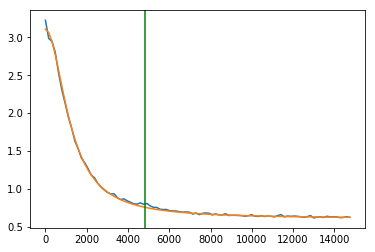

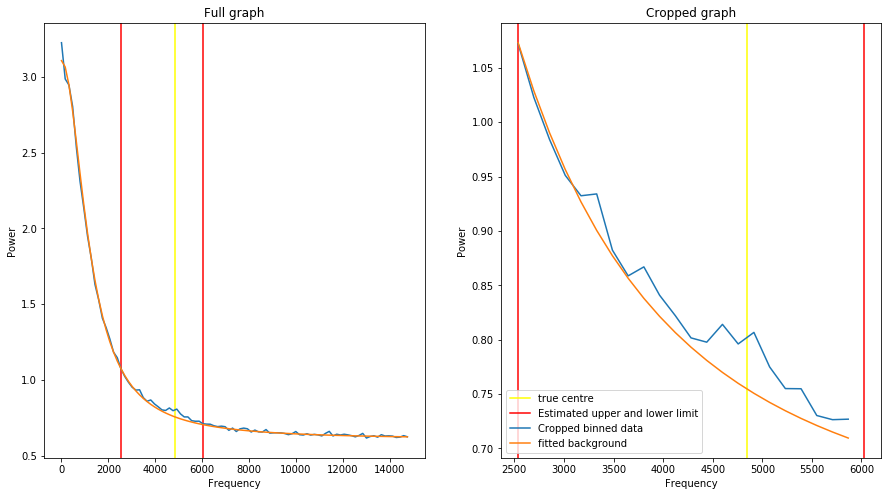

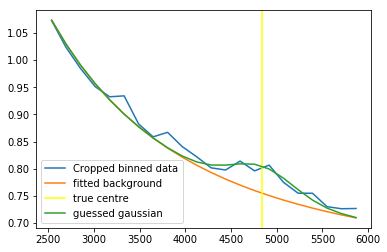

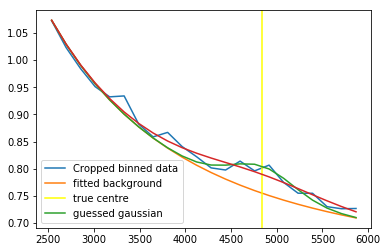

average v_max 4800.18415585113 which is -43.349421441479535 away from the true value of 4843.533577292609


In [35]:
frequency=data[0]
y,x=bin_it(addnoise(data[1]),frequency,6000)
plt.plot(x,y)
SN = 18*10**(-0.4*(11.0-extradata[0,2]))
p0=[0,0,0.1,extradata[0,1],300] #[A,tau,height,centre,width]
bv,covar =curve_fit(graneq,x,y,p0=[0,0])
background=graneq(x,bv[0],bv[1])
plt.plot(x,background)
plt.axvline(extradata[0,1],color='yellow')
#best_vals, covar =curve_fit(fullfit, x, y,p0=p0,maxfev=8000 )
#plt.plot(x,fullfit(x,best_vals[0],best_vals[1],best_vals[2],best_vals[3],best_vals[4]))
plt.show()
#lowerlim = input('Estimate the lower end of p modes: ')
#upperlim = input('Estimate the upper end of p modes: ') #user estimates the sides of the p modes
lowerlim=2500
upperlim=6000
lowerxindex=find_nearest(x,int(lowerlim))
upperxindex=find_nearest(x,int(upperlim)) 
fbackground=background[lowerxindex:upperxindex]
yf=y[lowerxindex:upperxindex]
xf=x[lowerxindex:upperxindex] #crops y and x array using entered limits xf and yf for xfinal and y final
fig, (ax1,ax2) = plt.subplots(1, 2 ,figsize=(15,8)) #genrates needed subplots
ax1.axvline(extradata[0,1],color='yellow',label='true centre')
ax1.axvline(int(x[lowerxindex]),color='red')
ax1.axvline(int(x[upperxindex]),color='red',label='Estimated upper and lower limit') #plots entered limits
ax1.set_xlabel('Frequency')
ax1.set_ylabel('Power')
ax1.set_title('Full graph')
ax1.plot(x,y,label='Binned data') 
ax1.plot(x,background,label='fitted background')
ax2.axvline(extradata[0,1],color='yellow',label='true centre')
ax2.axvline(int(x[lowerxindex]),color='red')
ax2.axvline(int(x[upperxindex]),color='red',label='Estimated upper and lower limit') #plots entered limits
ax2.plot(xf,yf,label='Cropped binned data')
ax2.plot(xf,fbackground,label='fitted background')
ax2.set_xlabel('Frequency')
ax2.set_ylabel('Power')
ax2.set_title('Cropped graph')
ax2.legend()
plt.show()
fittedgran=fbackground
plt.plot(xf,yf,label='Cropped binned data')
plt.plot(xf,fbackground,label='fitted background')
plt.axvline(extradata[0,1],color='yellow',label='true centre')
p0=[0.05,extradata[0,1],350]
plt.plot(xf,gausgran(xf,p0[0],p0[1],p0[2]),label='guessed gaussian')
plt.legend()
plt.show()
best_vals, covar = curve_fit(gausgran,xf,yf,p0=p0)
plt.plot(xf,yf,label='Cropped binned data')
plt.plot(xf,fbackground,label='fitted background')
plt.axvline(extradata[0,1],color='yellow',label='true centre')
p0=[0.05,extradata[0,1],350]
plt.plot(xf,gausgran(xf,p0[0],p0[1],p0[2]),label='guessed gaussian')
plt.plot(xf,gausgran(xf,best_vals[0],best_vals[1],best_vals[2]))
plt.legend()
plt.show()
print(f'average v_max {best_vals[1]} which is {best_vals[1]-extradata[0,1]} away from the true value of {extradata[0,1]}')

# this bit

Code is 25.0% complete :)
Code is 50.0% complete :)
Code is 75.0% complete :)
Code is 100.0% complete :)
0/1000 trails failed
average v_max 5011.691932708922 which is 168.1583554163126 away from the true value of 4843.533577292609


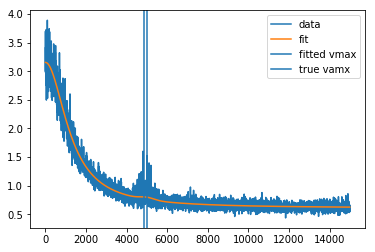

In [13]:
frequency=data[0]
N=1000
C=0
fails=0
amps=[]
centres=[]
widths=[]
while C<N:
    y,x=bin_it(addnoise(data[1]),frequency,120)
    SN = 18*10**(-0.4*(11.0-extradata[0,2]))
    p0=[0,0,0.1,extradata[0,1],300] #[A,tau,height,centre,width]
    bv,covar =curve_fit(graneq,x,y,p0=[0,0])
    background=graneq(x,bv[0],bv[1])
    fittedgran=background
    p0=[0.05,extradata[0,1],350]
    try:
        best_vals, covar = curve_fit(gausgran,x,y,p0=p0)
        amps.append(best_vals[0])
        centres.append(best_vals[1])
        widths.append(best_vals[2])
        C+=1
        if C % (25*(N/100)) == 0:
            print(f'Code is {C/(N/100)}% complete :)') #if statment that allows tracking of code completion while it is running
    except:
        fails+=1
        C+=1
        if C % (25*(N/100)) == 0:
            print(f'Code is {C/(N/100)}% complete :(') #if statment that allows tracking of code completion while it is running
if len(centres)>0:
    average_v_max=np.mean(centres)
    difference=np.abs(average_v_max-extradata[0,1])
    print(f'{fails}/{N} trails failed')
    print(f'average v_max {average_v_max} which is {difference} away from the true value of {extradata[0,1]}')
    plt.plot(x,y,label='data')
    plt.plot(x,gausgran(x,np.mean(amps),np.mean(centres),np.mean(widths)),label='fit')
    plt.axvline(np.mean(centres),label='fitted vmax')
    plt.axvline(extradata[0,1],label='true vamx')
    plt.legend()
    plt.show()
else:
    print('fails')

In [173]:
frequency=data[0]
m=np.linspace(1,len(data[:,0])-1,len(data[:,0])-1)

#m=[1]
N=100
binsize=120
#P = 1
#q=np.linspace(100,1000,20)
#for k in q:
for P in m:
    print(f'Star {int(P)}')
    print('')
    SN = 18*10**(-0.4*(11.0-extradata[int(P)-1,2]))
    print(f'SN: {SN}')
    x=data[int(P)]
    #x=x[round(len(x)/10):round(len(x)*4/10)]
    #frequency=frequency[round(len(frequency)/10):round(len(frequency)*4/10)]
    print(len(x))
    print(len(frequency))
    best= find_vmax(x,frequency,N,binsize,extradata[int(P)-1,1])
    xny=bin_it(addnoise(x),frequency,binsize)
    y=xny[0] 
    x=xny[1]
    best_vals=findgran(x,y)
    fittedgran=graneq(x,best_vals[0],best_vals[1])
    q_vals=[0.1,extradata[int(P)-1,1],300]
    plt.plot(x,gausgran(x,q_vals[0],q_vals[1],q_vals[2]))
    plt.plot(x,y)
    plt.axvline(extradata[int(P)-1,1],color='red')
    plt.plot(x,graneq(x,best[0],best[1]))
    plt.xlabel('Frequency')
    plt.ylabel('Power')
    plt.title(f'Star {int(P)}')
    plt.show()

Star 1

SN: 0.6065582374519263
567648
567648


ValueError: operands could not be broadcast together with shapes (4730,) (141,) 

In [172]:
frequency=data[0]
x = np.array(frequency)
binsize=90
C=0
Q=0
fails=0
centres=[]
widths=[]
amps=[]
N=4000 #number of trials to find v_max with differnt noise, 4000
while C<N:
    y=addnoise(Fulldata) #adds noise to y values, inside loop so each curve fit will be different due to the random noise
    yb,xb=bin_it(y,x,binsize) #yb and xb as in xbinned and ybinned bins data with a binsize of 50
    best_vals=findgran(xb,yb)
    fittedgran=graneq(xb,best_vals[0],best_vals[1])
    guess_vals=[np.max(yb),xb[0]+(xb[-1]-xb[0])/2,(xb[-1]-xb[0])/4] #rough guesses which will change with each plot
    #try and except are used in case a gaussian cant be fitted to the data. try and execpt allow the code to continue even if a
    #fit can not be found. If a fit can be found the v_max is recorded and added to an array of v_max values. If a fit can not
    #be found the failure is recored and the code continues with the next trial
    try: 
        best_vals, covar =curve_fit(gausgran, xb, yb,p0=guess_vals)
        #attempts to fit a gaussian to the data taking acount of the granulation
        '''section bellow can be used to look at indivudal results'''
        #if best_vals[1]<2400:
        #    if Q<2:
        #        plt.plot(xb,gausgran(xb,best_vals[0],best_vals[1],best_vals[2]))
        #        plt.plot(xb,yb)
        #        plt.axvline(best_vals[1],color='red')
        #        plt.show()
        #        Q+=1
    except:
        fails+=1 #records failure
        C+=1
        continue
    centres.append(best_vals[1])
    amps.append(best_vals[0])
    widths.append(best_vals[2])
    C+=1
    if C % (25*(N/100)) == 0:
        print(f'Code is {C/(N/100)}% complete') #if statment that allows tracking of code completion while it is running
percentage=fails*100/N
print(f'No fails: {fails}')
print(f'{percentage}% trails failed to fit a gaussian') 
if len(centres)<1: #prevents error is code
    print('Code failed to fit any gaussians ')
    print(fails)
else:   
    average_centres=np.mean(centres)
    difference=np.abs(average_centres-3100)
    print('')
    print(f'average v_max {average_centres} which is {difference} away from the true value of 3100 ')
    x_vals=bin_it(addnoise(Fulldata),x,binsize)[1]
    y_vals=bin_it(addnoise(Fulldata),x,binsize)[0]
    plt.plot(x_vals,y_vals, label='example data')
    plt.plot(x_vals,gausgran(x_vals,np.mean(amps),np.mean(centres),np.mean(widths)), 
             label='averaged fitted gaussian including granulation')
    plt.xlabel('Frequency')
    plt.ylabel('Power')
    plt.title('fitted gaussain ')
    plt.legend()
    plt.show()
    quater=int(len(x_vals)/4)
    plt.plot(x_vals[quater:3*quater],y_vals[quater:3*quater], label='example data')
    plt.plot(x_vals[quater:3*quater],gausgran1(x_vals[quater:3*quater],np.mean(amps),np.mean(centres),np.mean(widths)),
            label='fitted gaussian including granulation')
    plt.xlabel('Frequency')
    plt.ylabel('Power')
    plt.title('fitted gaussain cropped down')
    plt.legend()
    plt.show()
xs=np.linspace(1,N,N-fails)
plt.plot(xs,centres)
plt.xlabel('trails')
plt.ylabel('v_max')
plt.title(f'Each trials x_max for binsize {binsize}')
plt.show()
plt.scatter(xs,centres)
values_outside_expected_range=count(centres, 1000, 2900)
No_vals=len(centres)
print(f'{values_outside_expected_range}/{No_vals} are outside the expected range')

NameError: name 'Fulldata' is not defined

Number of trials 4000, binsize: 90, shot noise level -27
0.0% trails failed to fit a gaussian
average v_max 3113.114001532217 which is 13.114001532217117 away from the true value of 3100 

Number of trials 4000, binsize: 90, shot noise level -27
0.0% trails failed to fit a gaussian
average v_max 3112.6238980441735 which is 12.62389804417353 away from the true value of 3100 

Number of trials 4000, binsize: 90, shot noise level -27
0.0% trails failed to fit a gaussian
average v_max 3113.324056162413 which is 13.324056162412944 away from the true value of 3100 

Number of trials 4000, binsize: 90, shot noise level -27
0.025% trails failed to fit a gaussian
average v_max 3113.96487308663 which is 13.964873086630178 away from the true value of 3100 

Number of trials 4000, binsize: 90, shot noise level -27
0.0% trails failed to fit a gaussian
average v_max 3113.8345349012448 which is 13.834534901244751 away from the true value of 3100 

Number of trials 4000, binsize: 90, shot noise level 

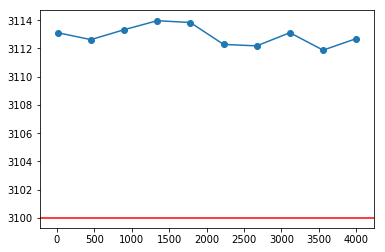

In [13]:
#loop of 4000 seems to be a good amount, its large enough to get a good value, but small enough to not run for a long time
#binsize of 90 seems to best
granulation = (4*np.sqrt(2)*tau_sun/1e6*(sigma_sun)**2)/(1+(2*np.pi*x*tau_sun/1e6)**4) #ppm squared per micro hertz
Fulldata=Lorentzh_array_0+Lorentzh_array_1+Lorentzh_array_2+Lorentzh_array_3+granulation
v_maxs=[]
error=[]
Ns=np.linspace(10,4000,10)
#binsizes=np.linspace(50,150,3)
for n in Ns:
    v_maxs.append(find_vmax(Fulldata,4000,90,-27))#data,No loops, binsize, 
v_maxs=np.array(v_maxs)
plt.plot(Ns,v_maxs)
plt.scatter(Ns,v_maxs)
plt.axhline(3100,color='r')
plt.show()
#shot_noise_levels=[1,2,3,4,5,6]
#for n in shot_noise_levels:
#    Q=find_vmax(4000,90,n)
#    v_maxs.append(np.mean(Q))
#    error.append(stdev(Q))
#plt.plot(shot_noise_levels,v_maxs)
#plt.scatter(shot_noise_levels,v_maxs)
#plt.axhline(3100,color='r')
#plt.xlabel('shot_noise_levels')
#plt.ylabel('v_max')
#plt.show()
#plt.plot(shot_noise_levels, error)
#plt.xlabel('shot_noise_levels')
#plt.ylabel('standard deviation of values')
#plt.show()
#print(error)